<a href="https://colab.research.google.com/github/fabianapagliuca/Deep-Learning/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning project - Garbage Classification**

## The dataset

This dataset, sourced from ([Garbage Classification](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)), contains **15,527** images from **12** different classes of household garbage:

1. paper (1050)
2. cardboard (891)
3. biological (985)
4. metal (769)
5. plastic (865)
6. green-glass (629)
7. brown-glass (607)
8. white-glass (775)
9. clothes (5325)
10. shoes (1777)
11. battery (945)
12. trash (697)

The **goal** of this project is to accurately classify each image into its respective class. Recycling garbage is crucial for environmental preservation.
Sorting garbage into groups with similar recycling processes facilitates and simplifies the recycling process.



In [ ]:
%%capture
pip install d2l==1.0.0a1.post0

In [ ]:
# import libraries

import torch.nn as nn
import random
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import random
from PIL import Image
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from d2l import torch as d2l
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
import torch.utils.data as data
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


Generate a list of strings containing the paths for the 12 classes in a different way. Then, to better understand the structure of the dataset we count the number of images for each category.

In [ ]:
directories = [
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/battery',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/biological',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/brown-glass',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/cardboard',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/clothes',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/green-glass',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/metal',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/paper',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/plastic',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/shoes',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/trash',
    '/content/drive/MyDrive/project dataset garbage/garbage_classification/white-glass'
]

In [ ]:
# count the number of images in each directory
for directory_path in directories:
    # get the categoty name from directory path
    category_name = os.path.basename(directory_path)

    # count number of images in the directory
    images_count = len(os.listdir(directory_path))

    print(f"Category: {category_name}, Number of images: {images_count}")

Category: battery, Number of images: 965
Category: biological, Number of images: 1005
Category: brown-glass, Number of images: 607
Category: cardboard, Number of images: 899
Category: clothes, Number of images: 5327
Category: green-glass, Number of images: 629
Category: metal, Number of images: 769
Category: paper, Number of images: 1050
Category: plastic, Number of images: 865
Category: shoes, Number of images: 1977
Category: trash, Number of images: 697
Category: white-glass, Number of images: 775


It's evident that the classes are highly imbalanced, with some categories having significantly more images than others. To address this issue, **downsampling** can be performed, where the larger classes are reduced to match the size of the smallest class.

## Balanced classes

To prepare the dataset for model training, we create **3** new folders: a **balanced training set**, a **balanced test set**, and a **balanced validation set**.
Each of these new folders should contain **12** subfolders, with each subfolder representing one of the **12** categories of garbage.


In [ ]:
#Create a directory parallel to the classes folder
!mkdir "/content/drive/MyDrive/project dataset garbage/garbage_classification/train_set_bal"
!mkdir "/content/drive/MyDrive/project dataset garbage/garbage_classification/test_set_bal"
!mkdir "/content/drive/MyDrive/project dataset garbage/garbage_classification/validation_set_bal"

In [ ]:
def create_balanced_sets(rootdir, train_path, test_path,
                         validation_path, num_images_per_category_train= 420,
                         num_images_per_category_test= 90,
                         num_images_per_category_validation= 90):
    '''Create balanced sets with a specific number of images per category'''

    # Set the random seed
    random.seed(42)

    for set_name in [train_path, test_path, validation_path]:
        set_path = os.path.join(rootdir, set_name)
        os.makedirs(set_path, exist_ok=True)

    for category_name in os.listdir(rootdir):
        category_path = os.path.join(rootdir, category_name)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)

            # Check if there are enough images in the category
            if len(images) >= num_images_per_category_train + num_images_per_category_test + num_images_per_category_validation:
                # Randomly select images for the training set
                selected_images_train = random.sample(images, num_images_per_category_train)

                # Randomly select images for the test set
                remaining_images = list(set(images) - set(selected_images_train))
                selected_images_test = random.sample(remaining_images, num_images_per_category_test)

                # Randomly select images for the validation set
                remaining_images = list(set(remaining_images) - set(selected_images_test))
                selected_images_validation = random.sample(remaining_images, num_images_per_category_validation)

                # Create directories for the sets and move the selected images
                for set_name, selected_images in zip([train_path, test_path, validation_path], [selected_images_train, selected_images_test, selected_images_validation]):
                    set_category_path = os.path.join(rootdir, set_name, category_name)
                    os.makedirs(set_category_path, exist_ok=True)
                    for image in selected_images:
                        source_path = os.path.join(category_path, image)
                        destination_path = os.path.join(set_category_path, image)
                        shutil.move(source_path, destination_path)

# Modify the root path with your directory structure
root_directory = '/content/drive/MyDrive/project dataset garbage/garbage_classification'
train_set_name = 'train_set_bal'
test_set_name = 'test_set_bal'
validation_set_name = 'validation_set_bal'
create_balanced_sets(root_directory, train_set_name, test_set_name, validation_set_name)

In [ ]:
def count_images_per_category(rootdir):
    '''Conta il numero di immagini in ogni categoria nei set'''
    for set_name in os.listdir(rootdir):
        set_path = os.path.join(rootdir, set_name)
        if os.path.isdir(set_path):
            print(f"Set: {set_name}")
            for category_name in os.listdir(set_path):
                category_path = os.path.join(set_path, category_name)
                if os.path.isdir(category_path):
                    num_images = len(os.listdir(category_path))
                    print(f"Category: {category_name}, Number of images: {num_images}")

# Modify the root path with your directory structure
root_directory = '/content/drive/MyDrive/project dataset garbage/garbage_classification'
count_images_per_category(root_directory)

Set: white-glass
Set: biological
Set: brown-glass
Set: clothes
Set: battery
Set: metal
Set: cardboard
Set: paper
Set: trash
Set: green-glass
Set: shoes
Set: plastic
Set: train_set_bal
Category: white-glass, Number of images: 420
Category: biological, Number of images: 420
Category: brown-glass, Number of images: 420
Category: clothes, Number of images: 420
Category: battery, Number of images: 420
Category: metal, Number of images: 420
Category: cardboard, Number of images: 420
Category: paper, Number of images: 420
Category: trash, Number of images: 420
Category: green-glass, Number of images: 420
Category: shoes, Number of images: 420
Category: plastic, Number of images: 420
Set: test_set_bal
Category: white-glass, Number of images: 90
Category: biological, Number of images: 90
Category: brown-glass, Number of images: 90
Category: clothes, Number of images: 90
Category: battery, Number of images: 90
Category: metal, Number of images: 90
Category: cardboard, Number of images: 90
Catego

Now, we can observe that the dataset is balanced, with each category having a similar number of images across different sets. Specifically, there are **420** images per category in the training set, which corresponds to **70%** of the class with the less number of images (baseline class), and the test and validation sets each contain **90** images per category (each accounting for **15%** of the baseline class).

## Images visualization

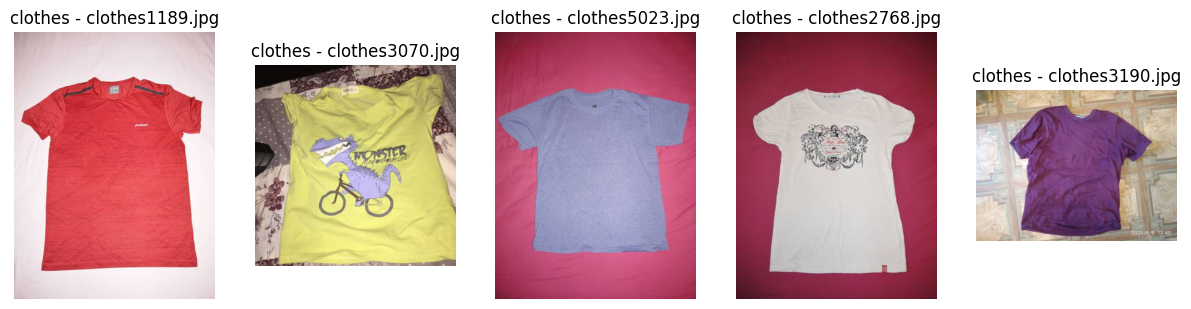

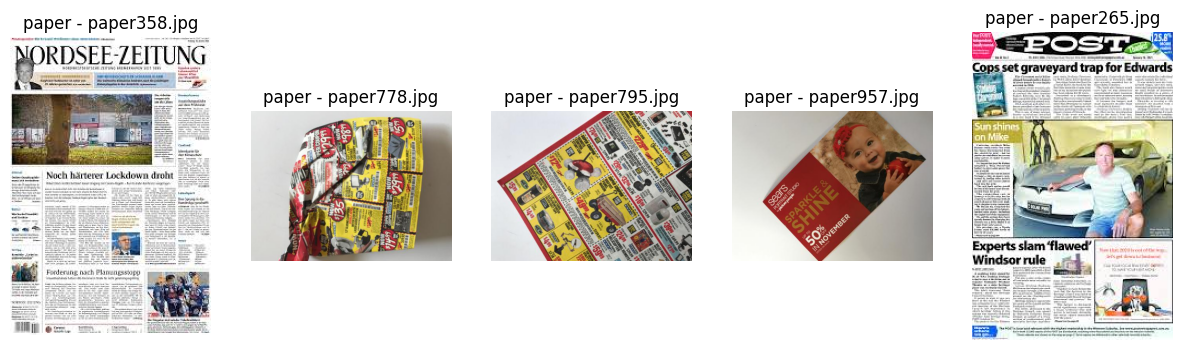

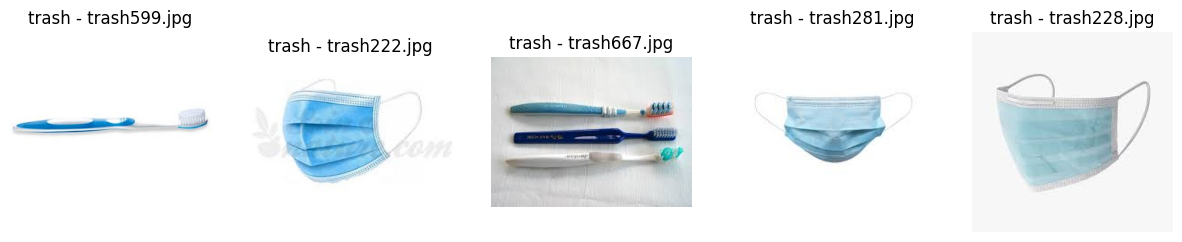

In [ ]:
def visualize_images(rootdir, set_name, category_name, num_images_to_visualize=5):
    set_path = os.path.join(rootdir, set_name, category_name)
    images = os.listdir(set_path)
    selected_images = random.sample(images, min(num_images_to_visualize, len(images)))

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images, 1):
        image_path = os.path.join(set_path, image_name)
        img = Image.open(image_path)

        plt.subplot(1, num_images_to_visualize, i)
        plt.imshow(img)
        plt.title(f"{category_name} - {image_name}")
        plt.axis('off')

    plt.show()

# Set the paths
root_directory = '/content/drive/MyDrive/project dataset garbage/garbage_classification'
test_set_name = 'test_set_bal'

# Visualize images in the test set for the selected category
visualize_images(root_directory, test_set_name, 'clothes')
visualize_images(root_directory, test_set_name, 'paper')
visualize_images(root_directory, test_set_name, 'trash')

In [ ]:
# Main directory containing subdirectories for each category
main_folder_path = '/content/drive/MyDrive/project dataset garbage/garbage_classification/train_set_bal'

# List of subdirectories (categories)
categories = os.listdir(main_folder_path)

# Number of images to randomly select for each category
num_images_per_category = 2

# Loop through the categories
for category in categories:
    category_folder_path = os.path.join(main_folder_path, category)
    if os.path.isdir(category_folder_path):
        # List of images in the category
        image_files = os.listdir(category_folder_path)

        # If there are enough images in the category, randomly select an image
        if len(image_files) >= num_images_per_category:
            random_images = random.sample(image_files, num_images_per_category)
            for image_file in random_images:
                image_path = os.path.join(category_folder_path, image_file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    mode = img.mode  # Image color format
                    print(f"Category: {category}, Name: {image_file}, Dimension: {width} x {height}, Color format: {mode}")
        else:
            print(f"Not enough images in category '{category}'.")



Category: green-glass, Name: green-glass100.jpg, Dimension: 224 x 224, Color format: RGB
Category: green-glass, Name: green-glass71.jpg, Dimension: 181 x 279, Color format: RGB
Category: clothes, Name: clothes2854.jpg, Dimension: 400 x 711, Color format: RGB
Category: clothes, Name: clothes930.jpg, Dimension: 400 x 533, Color format: RGB
Category: trash, Name: trash381.jpg, Dimension: 225 x 225, Color format: RGB
Category: trash, Name: trash28.jpg, Dimension: 225 x 225, Color format: RGB
Category: metal, Name: metal78.jpg, Dimension: 512 x 384, Color format: RGB
Category: metal, Name: metal295.jpg, Dimension: 512 x 384, Color format: RGB
Category: white-glass, Name: white-glass336.jpg, Dimension: 225 x 225, Color format: RGB
Category: white-glass, Name: white-glass138.jpg, Dimension: 512 x 384, Color format: RGB
Category: cardboard, Name: cardboard115.jpg, Dimension: 512 x 384, Color format: RGB
Category: cardboard, Name: cardboard528.jpg, Dimension: 258 x 195, Color format: RGB
Catego

The output displays information about randomly selected images from various categories within the dataset. Each entry specifies the category, image name, dimensions (**width x height**), and color format (**RGB**). Notably, all images in the dataset appear to be in the **RGB** color format.

Furthermore, it can be observed from the output that the images in the dataset exhibit diverse dimensions, as indicated by the varying width and height values. This highlights the significance of preprocessing techniques such as resizing or cropping to establish consistency in input dimensions during the training of machine learning models.

## Prepare the dataset for training

To increment the dataset size and improve performance, we apply data augmentation 4 times to the training dataset. Subsequently, the original training dataset is combined with the augmented data to form the final dataset.

In [ ]:
# Path to the new training_set folder
train_set_path = '/content/drive/MyDrive/project dataset garbage/garbage_classification/train_set_bal'
validation_set_path = '/content/drive/MyDrive/project dataset garbage/garbage_classification/validation_set_bal'
test_set_path = '/content/drive/MyDrive/project dataset garbage/garbage_classification/test_set_bal'

In [ ]:
# first augmentation: horizontal rotation

aug1 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(p=1),
  transforms.Resize((224,224))])

In [ ]:
# second augmentation: random crop and random rotation of 45 degrees

aug2 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop((224,224), scale=(0.1, 0.7), ratio=(0.5, 2)),
  transforms.RandomRotation(degrees = 45),
  transforms.Resize((224,224))])

In [ ]:
# third augmentation: modify images' brightness

aug3 = transforms.Compose([
  transforms.ToTensor(),
  transforms.ColorJitter(brightness=0.25, contrast=0, saturation=0, hue=0),
  transforms.Resize((224,224))])

In [ ]:
# fourth augmentation: perform random sharpness increments

aug4 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
  transforms.Resize((224,224))])

In [ ]:
# transform to tensor train folder without modifications

trans_without_aug = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224))])

In [ ]:
# implement transformations for validation folder

valid_trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224))])

In [ ]:
# implement transformations for test folder

test_trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224))])

Firstly, the code imports image data using the `ImageFolder` class  from the `torchvision.datasets` module. This class is particularly useful for loading image data organized in a directory structure where each subdirectory represents a distinct class.

Subsequently, the code prepares data loaders using the `DataLoader` class from the `torch.utils.data` module.

In [ ]:
# create the final joined dataset
l= [] #empty list

# append to the list folders with respective transformations
l.append(datasets.ImageFolder(root = train_set_path, transform = aug1))
l.append(datasets.ImageFolder(root = train_set_path, transform = aug2))
l.append(datasets.ImageFolder(root = train_set_path, transform = aug3))
l.append(datasets.ImageFolder(root = train_set_path, transform = aug4))
l.append(datasets.ImageFolder(root = train_set_path, transform = trans_without_aug))

# concatenate the dataset
train_iter = torch.utils.data.ConcatDataset(l)

# import validation dataset
valid_iter = datasets.ImageFolder(root = validation_set_path, transform = valid_trans)

# import test dataset
test_iter_IF = datasets.ImageFolder(root = test_set_path, transform = test_trans)

In [ ]:
# build data loaders
batch_size=64
train_iter = data.DataLoader(train_iter, batch_size, shuffle=True, num_workers= 2)
valid_iter = data.DataLoader(valid_iter, batch_size, shuffle=True, num_workers= 2)
test_iter_DL = data.DataLoader(test_iter_IF, batch_size, shuffle=True, num_workers= 2)

In [ ]:
def show_transformed_images(train_loader):
    batch = next(iter(train_loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("labels:", labels)
    plt.show()

labels: tensor([11,  2,  3,  1,  7,  2,  9, 11, 11,  6, 11,  5,  8,  7, 11,  5, 11,  2,
         4,  1,  5,  2,  6,  4,  7, 11,  4,  2,  1,  0,  3,  4,  1,  3, 11,  0,
         5,  6,  3,  0,  2,  7,  7,  4,  5,  5,  7,  7,  9,  1,  8,  8,  8, 11,
         3,  4, 11,  1, 11,  0, 11,  8,  6,  1])


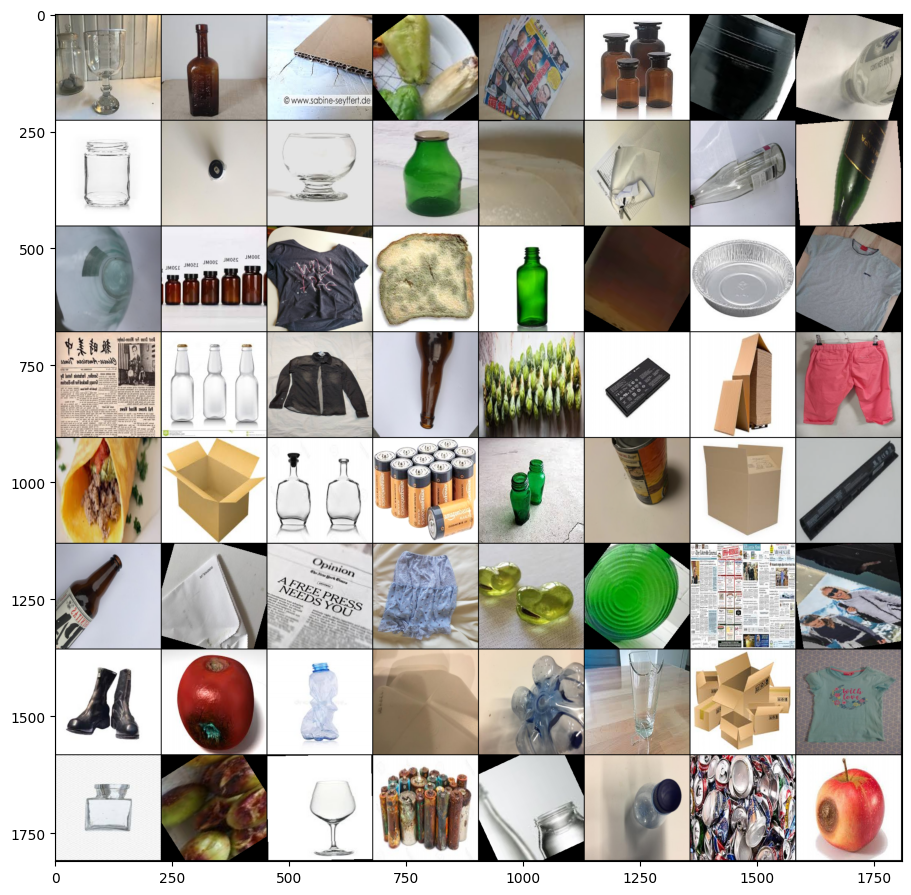

In [ ]:
show_transformed_images(train_iter)

# AlexNet

AlexNet is a convolutional neural network (CNN) introduced in 2012. It stands as one of the pioneering models to achieve high accuracy in image classification tasks on complex datasets like ImageNet.

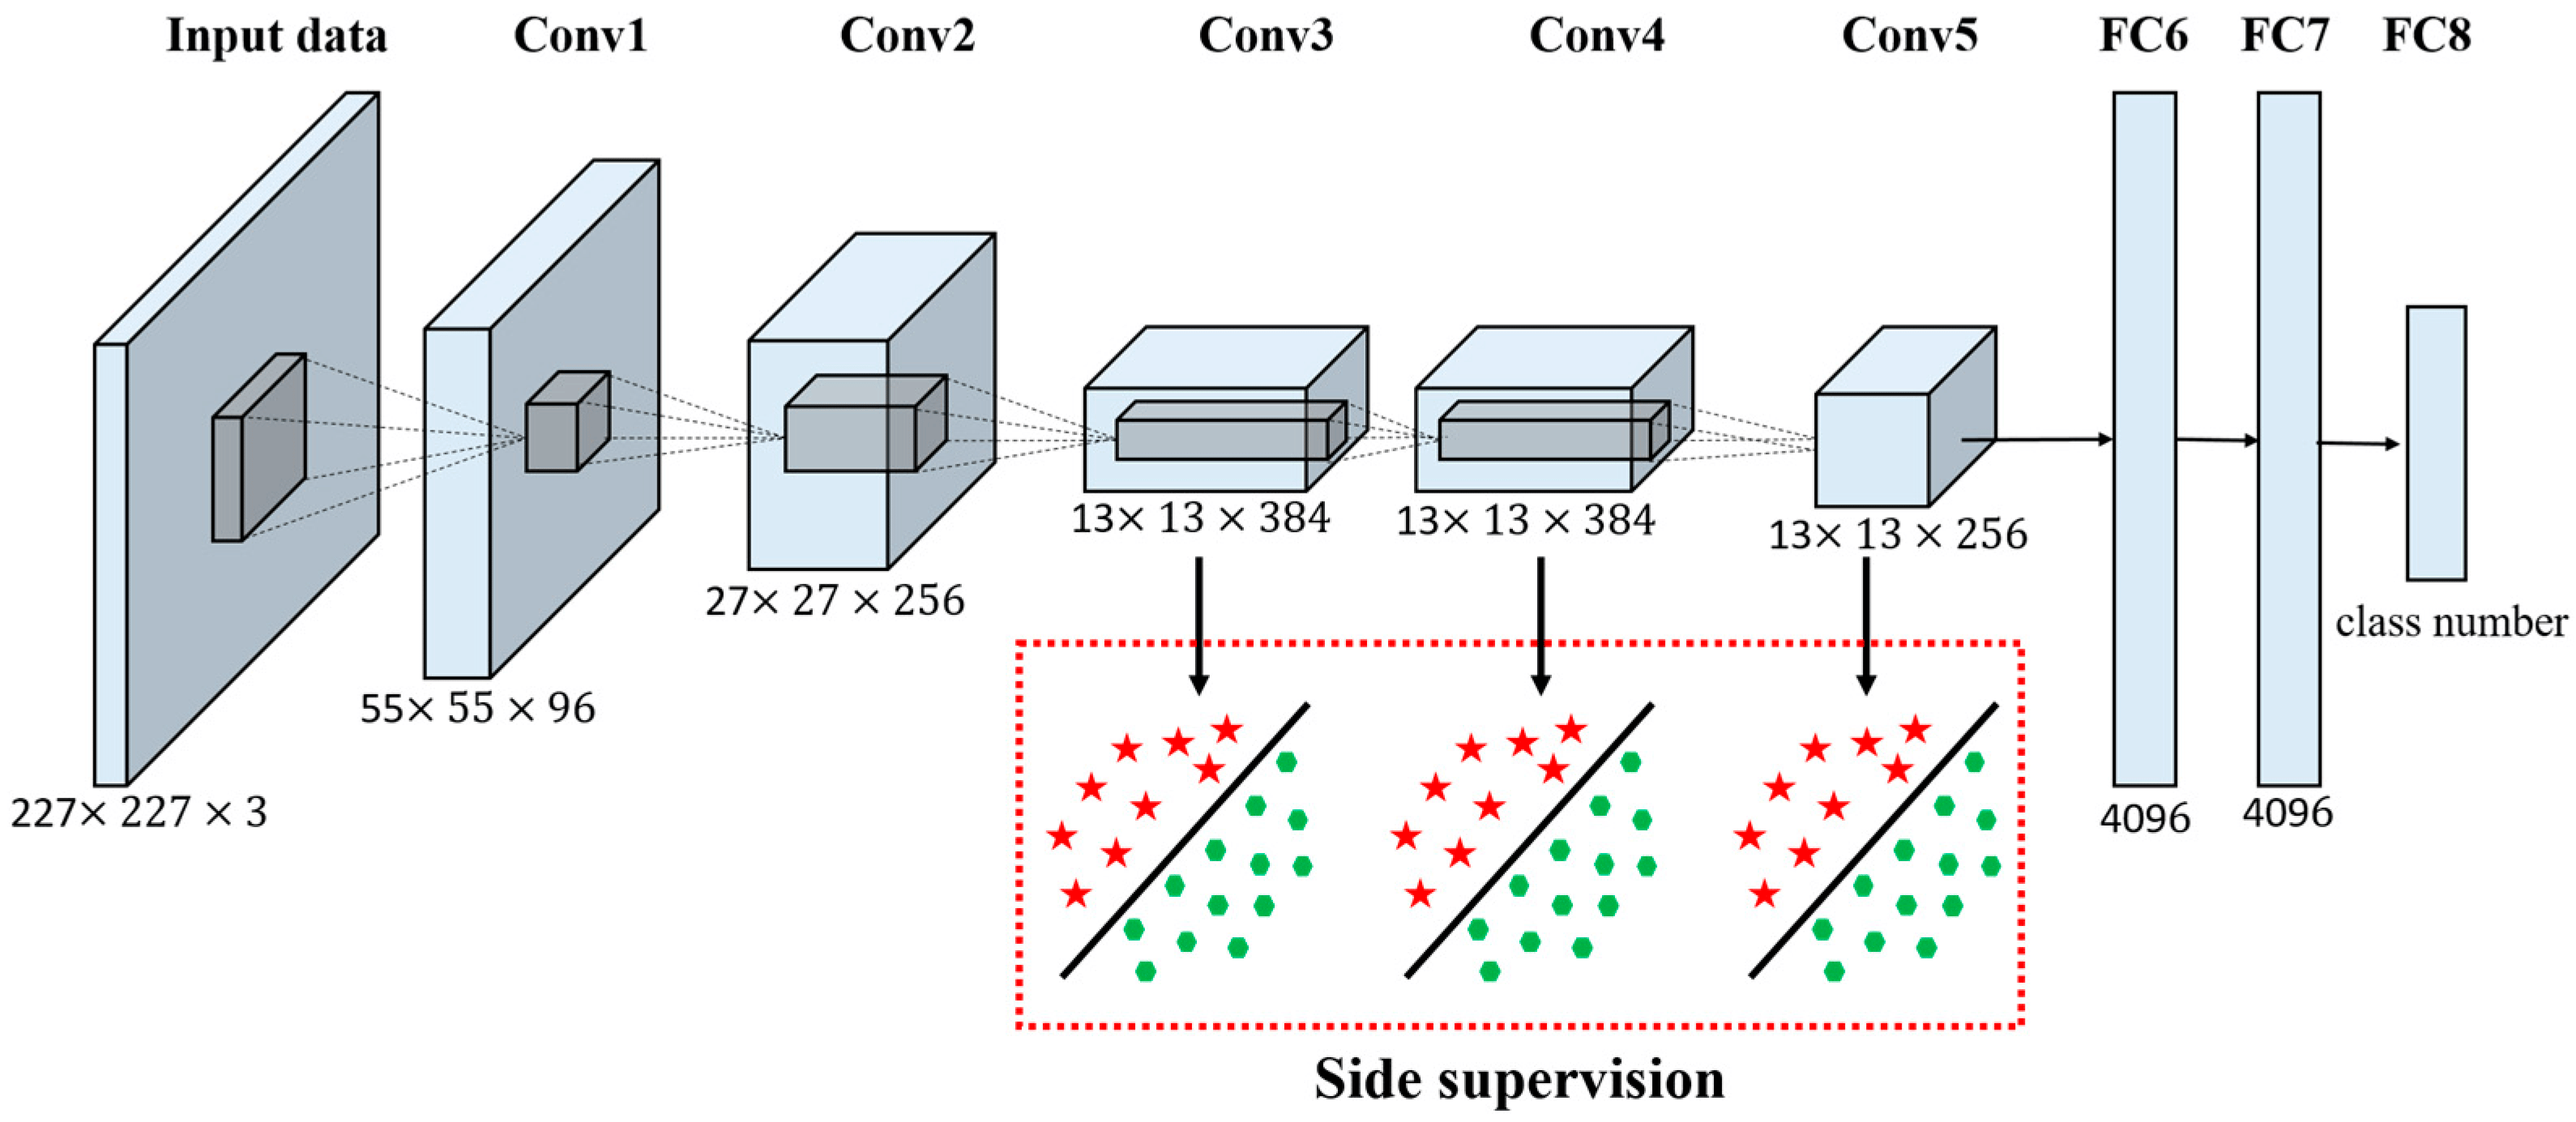

## Implement AlexNet architecture

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 12),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

The provided code implements the structure of AlexNet using PyTorch.
Sure, let's describe the various layers used in the AlexNet model:

1. **Convolutional Layers**:
   - The first convolutional layer (`nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)`) processes the input image with a kernel size of 11x11, generating 96 feature maps. It applies a stride of 4 and zero-padding of 2 to maintain the spatial dimensions.
   - The second convolutional layer (`nn.Conv2d(96, 256, kernel_size=5, padding=2)`) follows with 256 feature maps, using a kernel size of 5x5 and zero-padding of 2.
   - The third, fourth, and fifth convolutional layers (`nn.Conv2d(256, 384, kernel_size=3, padding=1)`, `nn.Conv2d(384, 384, kernel_size=3, padding=1)`, `nn.Conv2d(384, 256, kernel_size=3, padding=1)`) each have 384 and 256 feature maps, respectively, with a kernel size of 3x3 and padding of 1.

2. **Activation Function (ReLU)**:
   - Rectified Linear Unit (ReLU) activation functions (`nn.ReLU(inplace=True)`) are applied after each convolutional layer to introduce non-linearity into the network. It replaces all negative pixel values in the feature maps with zero, leaving positive values unchanged.

3. **Max Pooling Layers**:
   - Max pooling layers (`nn.MaxPool2d(kernel_size=3, stride=2)`) are utilized after the first, second, and fifth convolutional layers. They reduce the spatial dimensions of the feature maps by taking the maximum value within each specified kernel window (3x3) and moving the window by a stride of 2.

4. **Adaptive Average Pooling**:
   - The adaptive average pooling layer (`nn.AdaptiveAvgPool2d((6, 6))`) is used to adaptively average the spatial dimensions of the feature maps to a size of 6x6. This ensures that the output has a consistent size regardless of the input size.

5. **Dropout Layers**:
   - Dropout layers (`nn.Dropout(p=0.5)`) are applied twice in the classifier part of the network with a dropout probability of 0.5. They randomly deactivate units during training to prevent overfitting by introducing redundancy and promoting robustness.

6. **Fully Connected Layers**:
   - The fully connected layers (`nn.Linear()`) in the classifier section transform the output of the convolutional layers into the desired output size. The first fully connected layer has 4096 neurons, followed by ReLU activation, another dropout layer, and then another fully connected layer with 4096 neurons, ReLU activation, and finally a fully connected layer with 12 neurons, representing the output classes.


The code below initializes the AlexNet model, creates a random input tensor X with dimensions **(1, 3, 224, 224)** (assuming an **RGB** image), then passes this input through each layer of the network sequentially. After passing through each layer, it prints the name of the layer and the shape of the output tensor.

Now, we define the **accuracy** function:

$Accuracy=  \frac{TP  +  TN}{TOTAL}$

 were $TP$ + $TN$ represents the total number of corrected prediction and $TOTAL$ the total number of predictions.


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
model = AlexNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

The **cross-entropy loss** function (`nn.CrossEntropyLoss()`) is instantiated. This loss function is commonly used for multi-class classification problems, which makes it suitable for the final layer of the AlexNet model, which outputs class probabilities.

The **Adam optimizer** (optim.Adam) is initialized with a learning rate of **0.001** and is associated with the model parameters:

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

**Adam** is a variant of the **stochastic gradient descent (SGD)** method.

**Adam**: is a popular optimization algorithm used for training deep neural networks. It adjusts the learning rates of individual parameters *adaptively*, which can lead to faster convergence and better performance compared to traditional stochastic gradient descent (SGD), that uses a fixed learning rate throughout the entire training process.


**SGD** : Update the weights of the model using the gradient of the loss function against the current weights, multiplied by a constant learning rate.

## Training

In [ ]:
# set the seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

total_batch_train = len(train_iter)
total_batch_valid = len(valid_iter)

epochs = 10
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(epochs):
    # Training
    model.train()  # Imposta il modello in modalità di addestramento
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    for num, data in enumerate(train_iter):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss_list.append(total_loss_train / total_batch_train)
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()  # Imposta il modello in modalità di valutazione
    total_loss_valid = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for num, data in enumerate(valid_iter):
            val_images, val_labels = data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            total_loss_valid += val_loss.item()

            _, predicted_valid = torch.max(val_outputs.data, 1)
            total_valid += val_labels.size(0)
            correct_valid += (predicted_valid == val_labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    valid_loss_list.append(total_loss_valid / total_batch_valid)
    valid_acc_list.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss_list[-1]:.4f}, '
          f'Train Accuracy: {train_acc_list[-1]:.2f}%, '
          f'Validation Loss: {valid_loss_list[-1]:.4f}, '
          f'Validation Accuracy: {valid_acc_list[-1]:.2f}%')

print("Training Finished")


Epoch [1/10], Train Loss: 2.2615, Train Accuracy: 18.42%, Validation Loss: 2.0832, Validation Accuracy: 25.19%
Epoch [2/10], Train Loss: 1.7490, Train Accuracy: 38.51%, Validation Loss: 1.5014, Validation Accuracy: 47.96%
Epoch [3/10], Train Loss: 1.5302, Train Accuracy: 46.88%, Validation Loss: 1.3957, Validation Accuracy: 50.28%
Epoch [4/10], Train Loss: 1.3967, Train Accuracy: 51.73%, Validation Loss: 1.3364, Validation Accuracy: 54.91%
Epoch [5/10], Train Loss: 1.3029, Train Accuracy: 55.17%, Validation Loss: 1.2323, Validation Accuracy: 58.89%
Epoch [6/10], Train Loss: 1.1844, Train Accuracy: 59.52%, Validation Loss: 1.1749, Validation Accuracy: 62.22%
Epoch [7/10], Train Loss: 1.1079, Train Accuracy: 62.24%, Validation Loss: 1.2239, Validation Accuracy: 61.76%
Epoch [8/10], Train Loss: 1.0265, Train Accuracy: 65.35%, Validation Loss: 1.1973, Validation Accuracy: 60.37%
Epoch [9/10], Train Loss: 0.9376, Train Accuracy: 68.08%, Validation Loss: 1.0651, Validation Accuracy: 66.39%
E

-  **Training loss** decreases steadily from 2.262 to 0.866 over the course of training, indicating that the model is learning and improving.
- **Training accuracy** increases steadily from 18.42% to 70.56% in the final epoch, suggesting that the model is learning weel on training data.
-  **Validation loss** also decreases from 2.083 to 1.06, which is a good sign as it suggests that the model is generalizing well to unseen data, However, there's a slight uptick in validation loss around epoch 5.
-  **Validation accuracy** increases and decreasing during the training process, from 25.19% in the first epoch to 65.56% in the last, showing that the model is becoming more accurate in its predictions on the validation set.

Generally speaking, around epoch 7, we observe a slight overfitting phenomenon. This is indicated by the gap between the training and validation accuracies, coupled with a stagnation in validation accuracy improvement.

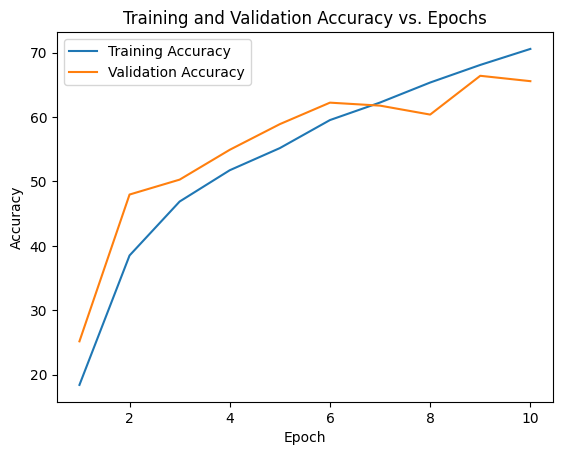

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]
plt.plot(epochs, train_acc_list, label='Training Accuracy')
plt.plot(epochs, valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.show()


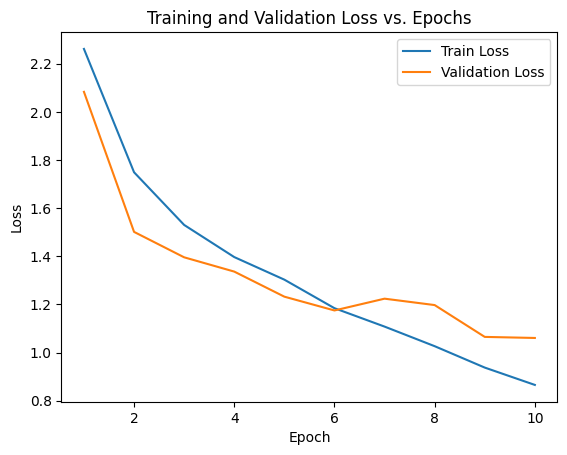

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]

plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.show()


## Testing

In [ ]:
# Test
model.eval()  # Imposta il modello in modalità di valutazione per il testing
total_loss_test = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for num, data in enumerate(test_iter_DL):
        test_images, test_labels = data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)
        test_loss = loss_fn(test_outputs, test_labels)
        total_loss_test += test_loss.item()

        _, predicted_test = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted_test == test_labels).sum().item()

test_accuracy = 100 * correct_test / total_test
test_loss = total_loss_test / len(test_iter_DL)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.1749, Test Accuracy: 64.44%


A test accuracy of 64.44% indicates that the model correctly classified 64 out of every 100 test images.  The test accuracy suggests that the model on the test set aligns  with the validation dataset, where the validation accuracy is 65.56%. This indicates that the model is reasonably robust in generalizing to unseen data, as its performance on the test set is consistent with its performance during validation.

## Prediction

### Image visualization

In this part, we aim to display a random subset of test images (n = 6) along with their true and predicted labels using the **AlexNet** neural network model and a test **data loader**.

In [ ]:
def show(net, test_loader, n=6, figsize=(15,20), scale_factor=0.1):

    class_labels = {
        0: 'Battery', 1: 'Biological', 2: 'brown-glass', 3: 'cardboard',
        4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper',
        8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'
    }


    # create two empty lists for real and predicted labels
    titles = []
    pred_titles = []

    # define index j to access values in lists above
    j = 0

    # access iteratively data loader elements
    x_iter, y_iter = next(iter(test_loader))

    # move x_iter to cuda to make predictions
    x_iter = x_iter.to(device)

    # make prediction with model and find the most probable class
    outputs = net(x_iter)
    _, pred = torch.max(outputs, 1)

    # define a random index to plot images randomly
    random_idx = random.sample(range(x_iter.size(0)), n)

    # move back x_iter to the CPU to allow comparisons
    x_iter = x_iter.cpu()

    for i in random_idx:
        # access single image and permute it to allow plotting
        img = x_iter[i].permute(1, 2, 0)

        # associate labels to indexes using class_labels dictionary
        true_label = class_labels[y_iter[i].item()]
        pred_label = class_labels[pred[i].item()]

        # append true and predicted labels to the lists
        titles.append(true_label)
        pred_titles.append(pred_label)

        # plot the image
        plt.imshow(img)
        # add title accessing j-th element in the list
        plt.title(f'True label: {true_label} \n Predicted label: {pred_label}')
        # show image
        plt.show()

        # increment the counter to access following elements of the lists
        j += 1



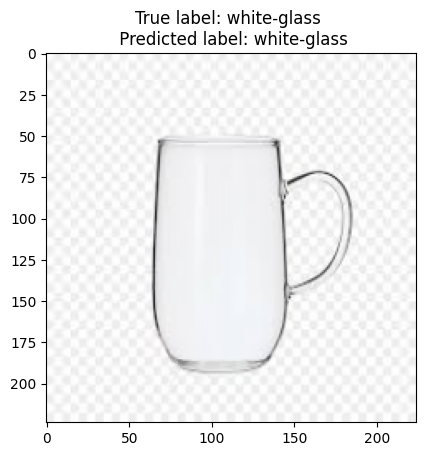

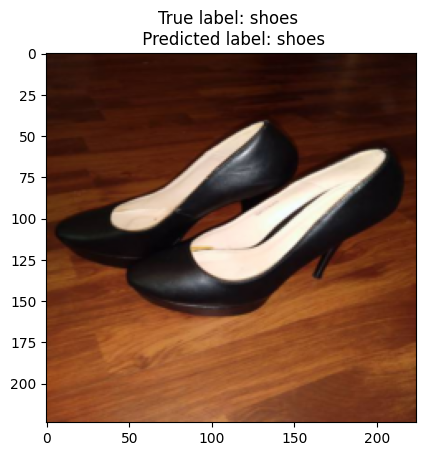

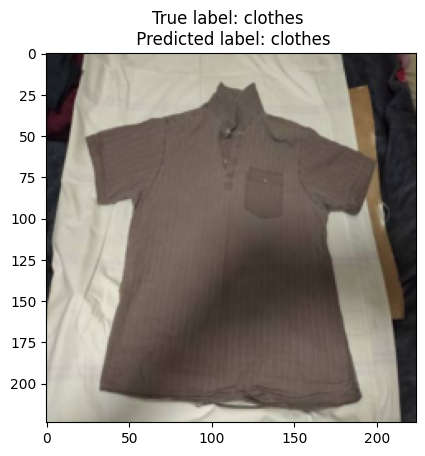

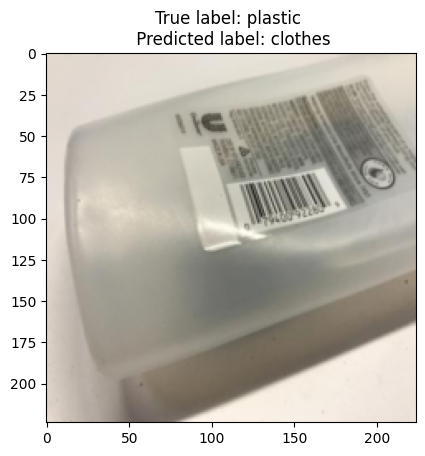

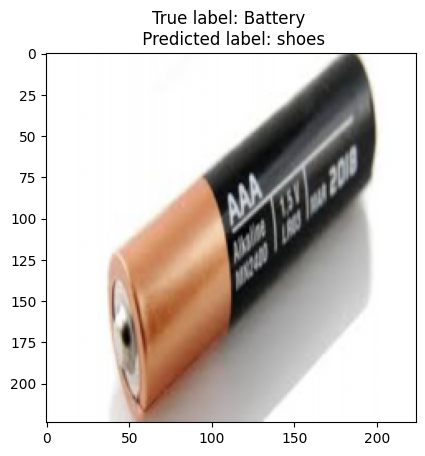

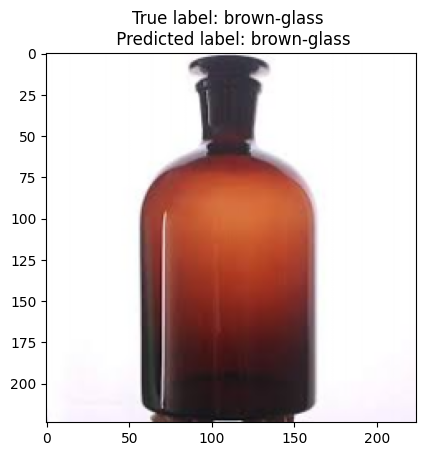

In [ ]:
show(model, test_iter_DL, n = 6)

In [ ]:
# create iterator for test set
data_test_iter = iter(test_iter_DL)
# get first bacth of test set
samples, labels = next(data_test_iter)
# move the input bacth on the GPU
samples = samples.to(device)

# Perform prediction on the input batch on the GPU
output = model(samples)

pred = []
Y = []
for i, (x,y) in enumerate(test_iter_DL):
    with torch.no_grad():
        x = x.to(device)
        outputs = model(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63        90
           1       0.67      0.84      0.75        90
           2       0.81      0.71      0.76        90
           3       0.85      0.76      0.80        90
           4       0.70      0.74      0.72        90
           5       0.83      0.91      0.87        90
           6       0.46      0.44      0.45        90
           7       0.58      0.58      0.58        90
           8       0.62      0.36      0.45        90
           9       0.63      0.49      0.55        90
          10       0.57      0.62      0.59        90
          11       0.48      0.59      0.53        90

    accuracy                           0.64      1080
   macro avg       0.65      0.64      0.64      1080
weighted avg       0.65      0.64      0.64      1080



This output provides a detailed evaluation using metrics such as **precision**, **recall**, and **F1-score** for each class, as well as overall accuracy and macro and weighted averages.

> - *Precision*: It measures the ratio of correctly predicted positive observations to the total predicted positives. Higher precision indicates fewer false positives.
- *Recall*: It calculates the ratio of correctly predicted positive observations to all actual positives. Higher recall indicates fewer false negatives.
- *F1-score*: It is the harmonic mean of precision and recall, providing a balanced measure of a model's performance.
- *Support*: It represents the number of actual occurrences of each class in the dataset.



Overall, the model achieves an accuracy of 64% on the test dataset. Looking at the individual class metrics, we observe variations in performance across different classes. For instance, classes 3 and 5 exhibit relatively high precision and F1_score, classes 1 and 5 shows the higher  recall score,  indicating strong performance in correctly identifying these classes. On the other hand, classes 6 and 12 demonstrate lower precision and F1-scores, classes 8 has the lowest recall suggesting challenges in accurately predicting these classes.

*Notice that the classes in the report are 0-indexed*

### Confusion matrix


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

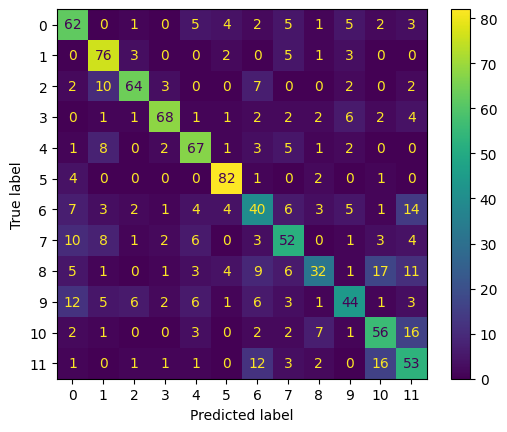

In [ ]:
cm = confusion_matrix(Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The confusion matrix is a graphical representation of the report above. It is a confirm that the model struggles more with correctly identifying instances of class 6, 8 and 9 often misclassifying them as other classes.

# GoogleNet

*GoogLeNet uses networks with parallel concatenations. It uses a stack of a total of 9 inception blocks which consist in 4 parallel paths and global average pooling to generate its estimates. Lastly, maximum pooling between inception blocks reduces the dimensionality.*

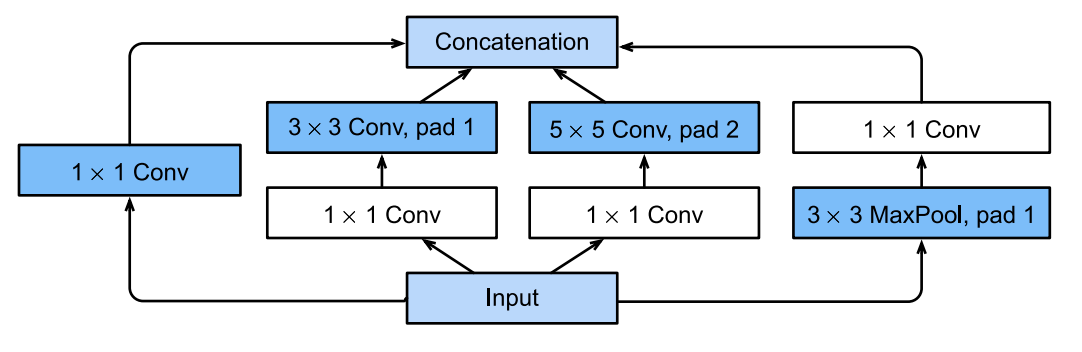

### Implement GoogleNet architecture

In [ ]:
# build inception blocks
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, input_ch, output_ch1, output_ch2, output_ch3, output_ch4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Build 4 parallel paths
        # Path 1: it uses a 1x1 convolutional layer
        self.p1_1 = nn.Conv2d(input_ch, output_ch1, kernel_size=1)
        # Path 2: is a 1x1 convolutional layer and it reduces the number of channels,
        # followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(input_ch, output_ch2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(output_ch2[0], output_ch2[1], kernel_size=3, padding=1)
        # Path 3: is a 1 x 1 convolutional layer and it reduces the number of channels,
        # followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(input_ch, output_ch3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(output_ch3[0], output_ch3[1], kernel_size=5, padding=2)
        # Path 4: is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(input_ch, output_ch4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

Build the architecture:

> *We implement the traditional GoogleNet architecture with some modifications. We decided to apply batch normalization layers to normalize data and to accelerate the covergence of the deep neaural network, implementing BatchNorm2d after each convolutional layer, before entering the nonlinear activation function.*
>
>*We also add the dropout layer before the fully connected linear layer at the end, with probability equal to 0.5, to avoid overfitting of the data.*
>
>
>*Lastly, we decided to add the LogSoftmax layer, which takes the logarithm of softmax probabilities. Having this layer allows us to reach numerical stability and lower the loss function since faster convergence to the optimum.*

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net1 = nn.Sequential(b1, b2, b3, b4, b5, nn.Dropout(p=0.5), nn.Linear(1024, 12), nn.LogSoftmax(dim = 1))

Let's break down the structure of the network:

1. **Block 1 (`b1`)**:
   - Begins with a 2D convolutional layer with 3 input channels, 64 output channels, a kernel size of 7x7, a stride of 2, and padding of 3.
   - Followed by batch normalization, ReLU activation, and max-pooling layer with a kernel size of 3x3, a stride of 2, and padding of 1.

2. **Block 2 (`b2`)**:
   - Consists of two convolutional layers with batch normalization and ReLU activation between them.
   - The first convolutional layer reduces the number of channels from 64 to 64 using a 1x1 kernel.
   - The second convolutional layer increases the number of channels from 64 to 192 using a 3x3 kernel with padding 1.
   - Ends with a max-pooling layer similar to Block 1.

3. **Block 3 (`b3`)**:
   - Employs the custom `Inception` module followed by max-pooling.

4. **Block 4 (`b4`)**:
   - Similar to Block 3, uses multiple instances of the `Inception` module.
   - Ends with max-pooling.

5. **Block 5 (`b5`)**:
   - Again, uses multiple instances of the `Inception` module.
   - Concludes with an adaptive average pooling layer followed by flattening the output.

6. **Final Layers**:
   - A dropout layer with a dropout probability of 0.5.
   - A fully connected linear layer that reduces the input features to 12 (assuming this is a classification task with 12 classes).
   - A LogSoftmax layer applied along the second dimension.


In [ ]:
X = torch.rand(size=(1, 3, 96, 96))
for layer in net1:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Dropout output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 12])
LogSoftmax output shape:	 torch.Size([1, 12])


## Training

In [ ]:
# set the seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


# Define the accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the optimization and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1 = net1.to(device)

total_batch_train = len(train_iter)
total_batch_valid = len(valid_iter)

epochs = 10
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(epochs):
    # Training
    net1.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    for num, data in enumerate(train_iter):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net1(images)
        loss = loss_fn(outputs, labels)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss_list.append(total_loss_train / total_batch_train)
    train_acc_list.append(train_accuracy)

    # Validation
    net1.eval()
    total_loss_valid = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for num, data in enumerate(valid_iter):
            val_images, val_labels = data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = net1(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            total_loss_valid += val_loss.item()

            _, predicted_valid = torch.max(val_outputs.data, 1)
            total_valid += val_labels.size(0)
            correct_valid += (predicted_valid == val_labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    valid_loss_list.append(total_loss_valid / total_batch_valid)
    valid_acc_list.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss_list[-1]:.4f}, '
          f'Train Accuracy: {train_acc_list[-1]:.2f}%, '
          f'Validation Loss: {valid_loss_list[-1]:.4f}, '
          f'Validation Accuracy: {valid_acc_list[-1]:.2f}%')

print("Training Finished")

Epoch [1/10], Train Loss: 2.0228, Train Accuracy: 27.50%, Validation Loss: 1.9721, Validation Accuracy: 30.83%
Epoch [2/10], Train Loss: 1.5713, Train Accuracy: 44.74%, Validation Loss: 1.3656, Validation Accuracy: 50.74%
Epoch [3/10], Train Loss: 1.4024, Train Accuracy: 51.63%, Validation Loss: 1.3032, Validation Accuracy: 54.26%
Epoch [4/10], Train Loss: 1.2660, Train Accuracy: 57.13%, Validation Loss: 1.1455, Validation Accuracy: 62.22%
Epoch [5/10], Train Loss: 1.1261, Train Accuracy: 62.54%, Validation Loss: 1.2815, Validation Accuracy: 58.15%
Epoch [6/10], Train Loss: 1.0120, Train Accuracy: 66.52%, Validation Loss: 1.1571, Validation Accuracy: 62.22%
Epoch [7/10], Train Loss: 0.9313, Train Accuracy: 69.21%, Validation Loss: 0.9318, Validation Accuracy: 68.89%
Epoch [8/10], Train Loss: 0.8415, Train Accuracy: 72.35%, Validation Loss: 0.9218, Validation Accuracy: 70.19%
Epoch [9/10], Train Loss: 0.7873, Train Accuracy: 74.17%, Validation Loss: 0.8494, Validation Accuracy: 73.24%
E

-  **Training loss** decreases steadily from 2.023 to 0.705 over the course of training, indicating that the model is learning and improving.
- **Training accuracy** improves from 27.50% in the first epoch reaching 76.74% in the last, demostrating the data is learning well on the training set.
-  **Validation loss** also decreases from 1.872 to 0.830, which is a good sign as it suggests that the model is generalizing well to unseen data.
-  **Validation accuracy** increases from 30.83% to 73.61%, showing that the model is becoming more accurate in its predictions on the validation set.


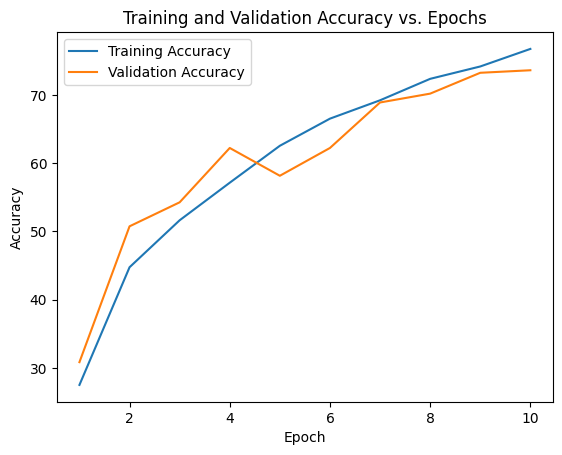

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]
plt.plot(epochs, train_acc_list, label='Training Accuracy')
plt.plot(epochs, valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.show()

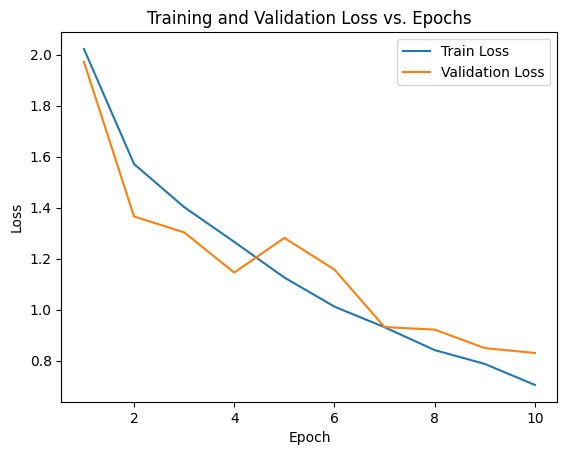

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]

plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.show()

## Testing

In [ ]:
# Test
net1.eval()  # Imposta il modello in modalità di valutazione per il testing
total_loss_test = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for num, data in enumerate(test_iter_DL):
        test_images, test_labels = data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = net1(test_images)
        test_loss = loss_fn(test_outputs, test_labels)
        total_loss_test += test_loss.item()

        _, predicted_test = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted_test == test_labels).sum().item()

test_accuracy = 100 * correct_test / total_test
test_loss = total_loss_test / len(test_iter_DL)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.9079, Test Accuracy: 72.78%


This process provides an evaluation of how well the trained model performs on unseen test data. After processing all batches in the test set, the overall accuracy is calculated as the percentage of correct predictions out of the total number of predictions.

The **accuracy** of our model on the test images is **72.78%**, indicating that the model has learned to generalize well from the training data to unseen data . This means that out of all the test images, approximately 73% were correctly classified by GoogleNet model.

## Prediction

### Image visualization

To visualize the performance of the neural network on the test dataset, we can randomly select a few images from the test set, make predictions using the trained model, and display the images along with their predicted labels.

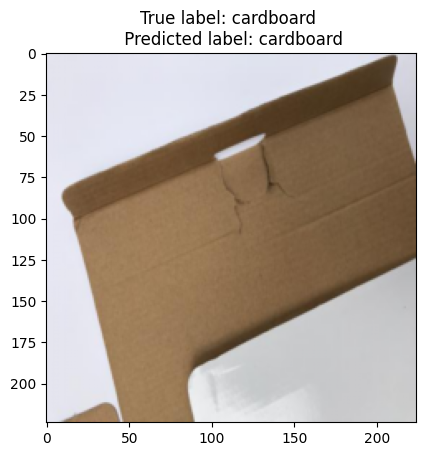

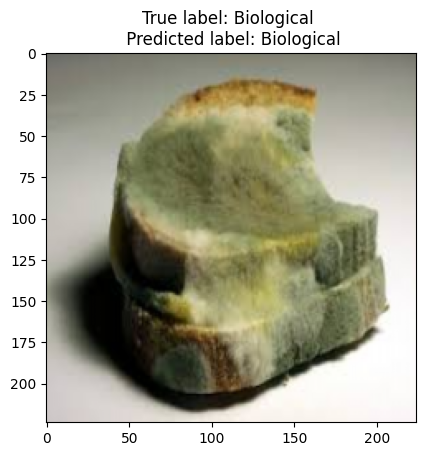

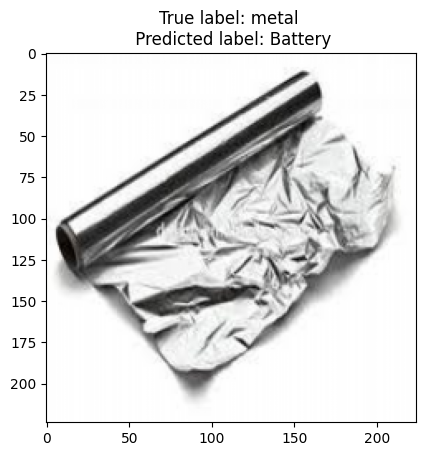

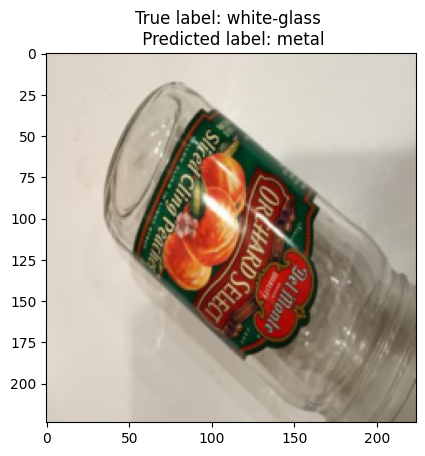

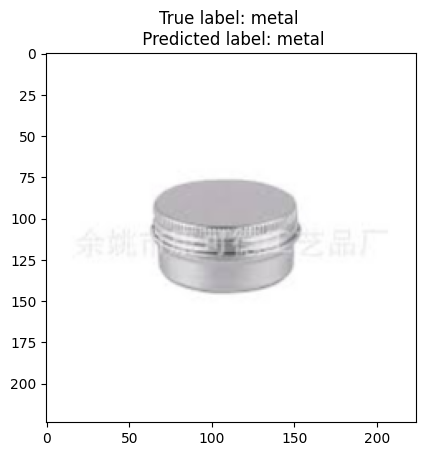

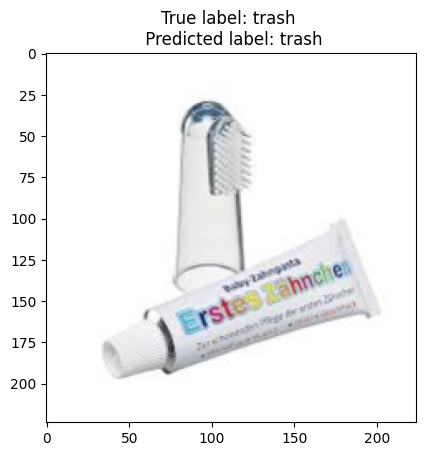

In [ ]:
show(net1, test_iter_DL, n=6)

In [ ]:
# create iterator for test set
data_test_iter = iter(test_iter_DL)
# get first bacth of test set
samples, labels = next(data_test_iter)
# move the input bacth on the GPU
samples = samples.to(device)

# Perform prediction on the input batch on the GPU
output = net1(samples)

pred1 = []
Y1 = []
for i, (x,y) in enumerate(test_iter_DL):
    with torch.no_grad():
        x = x.to(device)
        outputs = net1(x)
    pred1 += [int(op.argmax()) for op in outputs]
    Y1 += [int(yi) for yi in y]

print(classification_report(Y1, pred1))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71        90
           1       0.78      0.80      0.79        90
           2       0.82      0.83      0.82        90
           3       0.79      0.86      0.82        90
           4       0.71      0.71      0.71        90
           5       0.92      0.88      0.90        90
           6       0.53      0.68      0.59        90
           7       0.66      0.74      0.70        90
           8       0.62      0.59      0.61        90
           9       0.68      0.57      0.62        90
          10       0.80      0.79      0.79        90
          11       0.73      0.62      0.67        90

    accuracy                           0.73      1080
   macro avg       0.73      0.73      0.73      1080
weighted avg       0.73      0.73      0.73      1080



These metrics provide insights into how well the model performs on each class individually. For instance, classes with high precision and recall scores (e.g., Class 5) indicate that the model performs well in correctly identifying those classes. On the other hand classes with a lower score (e.g. class 6) tend to misclassifying some instances. Overall, the weighted average accuracy is reported as 0.73, which aligns with the overall accuracy previously reported.

### Confusion matrix

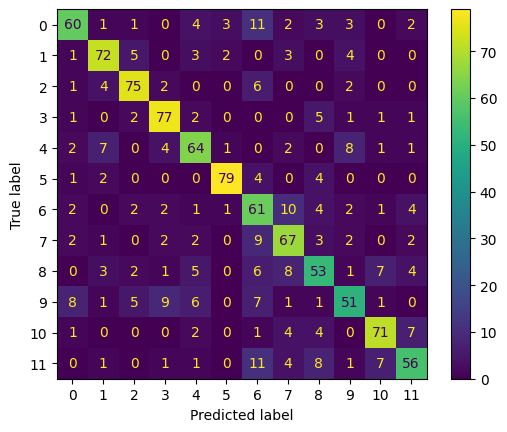

In [ ]:
cm1 = confusion_matrix(Y1, pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

The confusion matrix above shows the true labels against the predicted labels and helps us understand which classes are being confused with each other by your model.

Looking at the confusion matrix, we observe that class 5 exhibits a high precision of 79, indicating that when the true label is class 5, the model correctly predicts it as such in 79% of the cases. On the contrary, class 9 demonstrates a lower precision of 51, implying that the model struggles more with correctly identifying instances of class 9, often misclassifying them as other classes (e.g. class 3).

*Notice that the classes in the confusion matrix are 0-indexed*

# Conclusions

The project aimed to classify images into 12 different garbage classes. The dataset was splitted into training, validation, and test sets, with balanced classes across all sets.

Then different types of data augmentation techniques were applied to the training dataset to increase its size and improve model performance. Four augmentation methods are used: horizontal rotation, random crop and rotation, modification of brightness, and random sharpness increments.

AlexNet and GoogLeNet architectures are implemented.

Both models are trained using the Adam optimizer and cross-entropy loss function.


For the first model, we implemented **AlexNet** which took about **54 minutes** to execute and trained on about 25200 images.
The **training accuracy** is about **70.56%** in the final epoch and **test set accuracy** is **64.44%**.

For the second model, we implemented **GoogLeNet** which took about **43 minutes** to execute and trained on the same dataset as the first model.
In this case, the training accuracy of **GoogLeNet** grows from around **27.5%** in the first epoch to about **76.74%** in the final epoch.
While, the **test set accuracy** of GoogLeNet is **72.78%**, showing better performance compared to AlexNet: GoogLeNet also outperforms AlexNet in test data accuracy.
This model shows a more significant improvement and higher overall accuracy compared to AlexNet.


Analyzing the confusion matrix and classification metrics for both models, it can be observed that GoogLeNet outperforms AlexNet in the ability to discriminate between different waste classes. While AlexNet shows some difficulty in classes 6 and 8, GoogLeNet appears to handle the classification of these classes better.


Overall, GoogLeNet shows superior performance compared to AlexNet on all evaluated metrics. The more complex structure of GoogLeNet, which includes Inception blocks and several other regularization techniques like dropout, seems to have contributed to the overall improvement in model performance.